Here, we look closer look to try and determine whether the US segment should be labelled under the NL or SH segment class. 

### Load dataframe

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos"

In [6]:
DT_ID = '2022-03-04_18-41-29'

In [7]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_for_umap.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH


In [8]:
seg_df.sort_values(by=['ID'], inplace=True)

In [9]:
segs = np.array(["NL", "SH", "US"])

In [10]:
##subset dataframe of combis if label is in array on sequences with NL
df = seg_df.loc[seg_df.labels.isin(segs)]  
df[:2]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
3,0.932017,0.942875,SH,3,0.932017,0.942875,SHSHLH,0.932017,0,1,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH


In [11]:
df.labels.unique()

array(['SH', 'US', 'NL'], dtype=object)

In [12]:
len(df)

662

In [13]:
len(df.loc[df["labels"]=="SH"])

482

In [14]:
len(df.loc[df["labels"]=="NL"])

173

### Create balanced dataset where counts of SH and NL segments are balanced

In [15]:
SHdf = df.loc[(df["labels"]=="SH")]
SHdf[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
3,0.932017,0.942875,SH,3,0.932017,0.942875,SHSHLH,0.932017,0,1,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH
4,0.951561,0.980101,SH,4,0.951561,0.980101,SHSHLH,0.932017,1,1,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH


In [16]:
#check number of segments per individual
labels_dfs = []
for indv in np.sort(seg_df.indv.unique()):
    labels_df = pd.DataFrame({i:[np.sum(seg_df[seg_df.indv == indv].labels == i)] for i in seg_df[seg_df.indv == indv].labels.unique()})
    labels_df.insert(0, 'indv', indv)
    labels_dfs.append(labels_df)
ls_df = pd.concat(labels_dfs)
ls_df.sort_values(by=['indv'])
ls_df[:]

,indv,NL,DS,LH,SH,US,HL
0,BMYO,10.0,43,13.0,17.0,1.0,NaN
0,GBYM,15.0,18,8.0,30.0,NaN,8.0
0,GON XF 19-21,2.0,9,6.0,19.0,NaN,NaN
0,GON XM 20-21,3.0,5,1.0,1.0,NaN,NaN
0,MGGY,7.0,31,10.0,29.0,1.0,1.0
0,MOGO,18.0,36,9.0,40.0,1.0,NaN
0,MOOO,1.0,13,6.0,5.0,4.0,NaN
0,MORP,3.0,9,4.0,NaN,NaN,NaN
0,MOVY,5.0,10,5.0,NaN,NaN,NaN
0,MRGO,10.0,41,12.0,62.0,NaN,NaN


In [17]:
#Take random sample of unique SH segments
segs = [i for i in SHdf.ID.unique()]
select = pd.DataFrame(segs)
select = select.astype(int)
samps = select.sample(frac = 0.358) 
ds = list(samps[0])
len(ds)

173

In [18]:
SH_df = SHdf.loc[SHdf.ID.isin(ds)]  ##subset dataframe of sequences if their number is in random sample
SH_df[:2]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
1,0.334214,0.388437,SH,14,0.334214,0.388437,DSSHDS,0.306330,1,6,...,BWY MGGY Discrete 4 210519 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Discrete 4 210519 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
1,0.205844,0.258040,SH,19,0.205844,0.258040,DSSHDS,0.158063,1,8,...,BWY MGGY Discrete 6 210519 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Discrete 6 210519 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH


In [19]:
len(SH_df)

173

In [20]:
#check number of segments per individual again
labels_dfs = []
for indv in np.sort(SH_df.indv.unique()):
    labels_df = pd.DataFrame({i:[np.sum(SH_df[SH_df.indv == indv].labels == i)] for i in SH_df[SH_df.indv == indv].labels.unique()})
    labels_df.insert(0, 'indv', indv)
    labels_dfs.append(labels_df)
ls_df = pd.concat(labels_dfs)
ls_df.sort_values(by=['indv'])
ls_df[:]

,indv,SH
0,BMYO,4
0,GBYM,13
0,GON XF 19-21,11
0,MGGY,11
0,MOGO,13
0,MOOO,3
0,MRGO,23
0,MXWW,4
0,MXXGRY,8
0,OMGO,29


In [21]:
other_df = df[df["labels"].isin(["SH"])==False] #without SH
other_df.labels.unique()

array(['US', 'NL'], dtype=object)

In [22]:
#attach to dataframe with NL & US segments
frames = [other_df, SH_df]
df2 = pd.concat(frames)
df2[:2]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
1,1.442686,1.472619,US,7,1.442686,1.472619,USHL,1.442686,0,3,...,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",US-HL,DS US-HL
3,0.338289,0.439778,NL,26,0.338289,0.439778,NLSHDS,0.338289,0,11,...,BWY MGGY Excitement 2 170519 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Excitement 2 170519 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NL-SH-DS,DS-SH-DS NL-SH-DS


### Spectrograms for all individuals

In [23]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [24]:
df2 = df2[np.array([np.sum(i) > 0.0 for i in df2.specs.values])
]

In [25]:
specs = list(df2.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/353 [00:00<?, ?it/s]

(353, 4096)

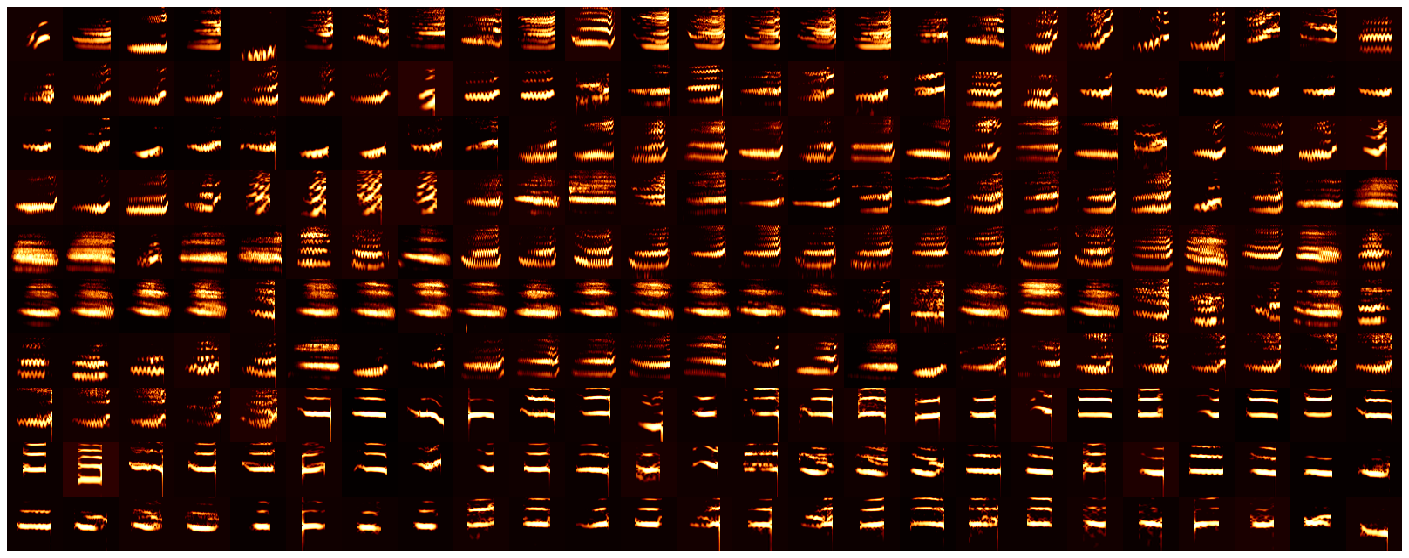

In [26]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

## Project

In [27]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Sep 11 12:17:44 2022 Finding Nearest Neighbors
Sun Sep 11 12:17:46 2022 Finished Nearest Neighbor Search
Sun Sep 11 12:17:47 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep 11 12:17:49 2022 Finished embedding


In [28]:
df2['umap'] = list(z)

## View UMAP

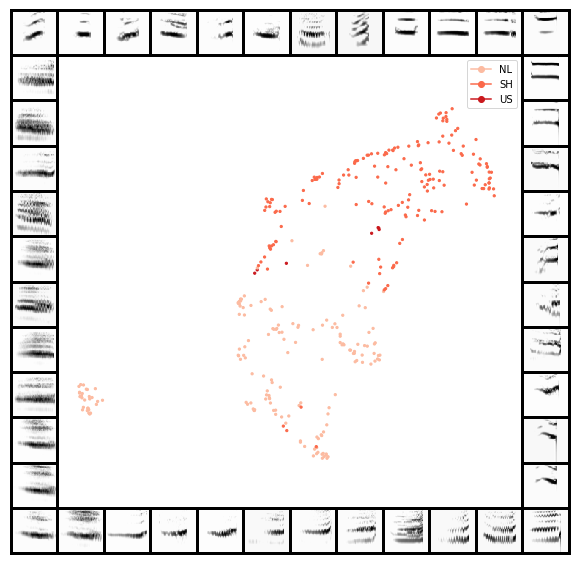

In [29]:
nex = -1
scatter_spec(
    np.array(list(df2['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-14,14],
    #y_range = [-14,15],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': df2.labels.values,
        'alpha':1,
        's': 5,
        'show_legend': True,
        "color_palette": 'Reds',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=False,
    n_subset= 1000,
    border_line_width = 3,
    

);

## Silhouette Score

In [30]:
from avgn.clusterability.silhouette import nn, sil, plot_within_without

In [31]:
# labels
labels = df2['labels']

In [32]:
embedding = np.asarray(list(df2['umap'])) # UMAP coordinates

In [33]:
knn=5 #  for knn=5 nearest neighbors

nn_stats = nn(embedding, np.asarray(labels), k=knn)

In [34]:
import seaborn as sns

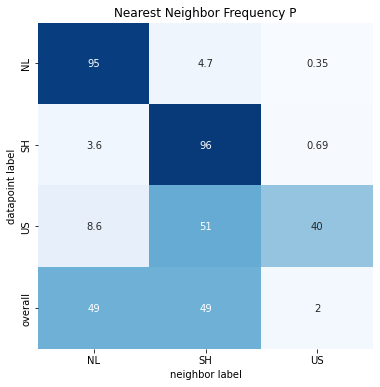

In [35]:
nn_stats.plot_heat_S(vmin=0,       # lower end (for color scheme)
                     vmax=100,     # upper end (for color scheme)
                     center=50,    # center(for color scheme)
                     cmap=sns.color_palette("Blues", as_cmap=True),# color scheme 
                     cbar=None,    # show colorbar if True else don't
                     outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

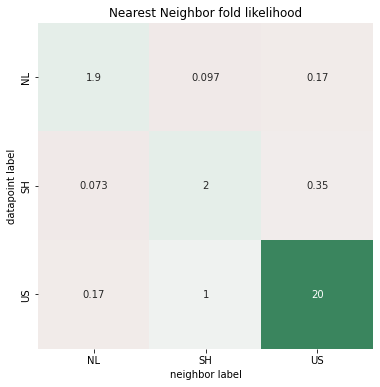

In [36]:
nn_stats.plot_heat_fold(center=1,    # center(for color scheme)
                        cmap=sns.diverging_palette(20, 145, as_cmap=True),# color scheme 
                        cbar=None,    # show colorbar if True else don't
                        outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

Judging from these results, it is most likely the US segment fits into the SH segment class. As such, we will create a combined label column in our dataframe (next notebook). 

In [37]:
#save df
save_loc = DATA_DIR / DATASET_ID / DT_ID /  'CheckUSLabel.pickle'
ensure_dir(save_loc.as_posix())
df2.to_pickle(save_loc)